<a href="https://colab.research.google.com/github/dldmstj0531/GEC/blob/main/notebooks/EDA/EDA_C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **C4-200M**

In [1]:
!pip install -q koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 35.0 MB/s eta 0:00:00


In [2]:
!pip install python-Levenshtein seaborn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.3 MB/s eta 0:00:00


In [3]:
import warnings, os, json, ast, math, pathlib, shutil
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from collections import Counter
import difflib
import Levenshtein
from pathlib import Path

In [4]:
# pandas 출력 옵션 및 경고 설정
pd.set_option("display.max_columns", 120)
warnings.filterwarnings("ignore")

# tqdm의 pandas integration 활성화
tqdm.pandas()

# 마이너스 기호 깨짐 방지
sns.set(style="whitegrid")
plt.rcParams["axes.unicode_minus"] = False

# NLTK 토크나이저 다운로드 (최초 1회 필요)
nltk.download("punkt")

# 시각화 스타일 설정
sns.set(style="whitegrid")
plt.rcParams["axes.unicode_minus"] = False # 마이너스 기호 깨짐 방지

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Colab 전용: tqdm, pandas, matplotlib 설치/업데이트
!pip -q install pandas tqdm matplotlib

# 구글 드라이브 마운트: EDA 결과물만 저장하고, 대형 TSV는 /content 에 임시 저장 권장
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## 1. 데이터 준비

### - 각 샤드 다운받기

In [6]:
import os, json, pathlib

# 드라이브에 있는 kaggle.json 경로
kaggle_src = "/content/drive/MyDrive/Projects/kaggle.json"

# 대상 경로(/root/.kaggle)로 복사 + 퍼미션 설정
kaggle_dst_dir = pathlib.Path("/root/.kaggle")
kaggle_dst_dir.mkdir(parents=True, exist_ok=True)

if not os.path.exists(kaggle_src):
    raise FileNotFoundError(f"kaggle.json이 없습니다: {kaggle_src}")

shutil.copyfile(kaggle_src, kaggle_dst_dir / "kaggle.json")
os.chmod(kaggle_dst_dir / "kaggle.json", 0o600)

print("kaggle.json 복사 및 권한 설정 완료.")

# kaggle CLI 설치 및 간단 확인
!pip -q install kaggle
!kaggle -h | head -n 3

kaggle.json 복사 및 권한 설정 완료.
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...


In [7]:
KAGGLE_DATASET = "felixstahlberg/the-c4-200m-dataset-for-gec"  # <-- 실제 슬러그로 교체

# 목록만 먼저 확(용량 파악, 파일명 확인)
!kaggle datasets files {KAGGLE_DATASET}

name                            size  creationDate                
------------------------  ----------  --------------------------  
edits.tsv-00000-of-00010  2992601947  2021-05-26 18:59:22.840000  
edits.tsv-00001-of-00010  2990782945  2021-05-26 19:00:11.393000  
edits.tsv-00002-of-00010  2991847440  2021-05-26 19:00:57.927000  
edits.tsv-00003-of-00010  2990847051  2021-05-26 19:01:38.295000  
edits.tsv-00004-of-00010  2991463256  2021-05-26 19:02:19.945000  
edits.tsv-00005-of-00010  2992038211  2021-05-26 19:03:00.175000  
edits.tsv-00006-of-00010  2992255660  2021-05-26 19:03:41.023000  
edits.tsv-00007-of-00010  2993397600  2021-05-26 19:04:18.859000  
edits.tsv-00008-of-00010  2991033963  2021-05-26 19:05:03.250000  
edits.tsv-00009-of-00010  2991637077  2021-05-26 19:05:42.223000  


In [8]:
import subprocess, re, os, sys, textwrap

# 원하는 샤드 인덱스 지정 (예: 0, 1 두 개만)
TARGET_SHARDS = [0,1,2,3,4,5,6,7,8,9]

# 파일 패턴 예상. 목록에서 실제 이름을 확인한 후 패턴을 맞추세요.
def shard_name(idx: int) -> str:
    return f"edits.tsv-{idx:05d}-of-00010"

# 어디에 저장할지 지정
download_dir = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m_edits"
os.makedirs(download_dir, exist_ok=True)

# 샤드별로 단건 다운로드
for i in TARGET_SHARDS:
    fname = shard_name(i)
    print(f"Downloading {fname} ...")
    # --force 사용해 동일 파일이 있어도 재시도 가능
    !kaggle datasets download {KAGGLE_DATASET} -f {fname} -p {download_dir} --force
    # Kaggle는 zip으로 떨어질 수 있음 -> 풀기
    zip_path = os.path.join(download_dir, fname + ".zip")
    if os.path.exists(zip_path):
        !unzip -o {zip_path} -d {download_dir}
        os.remove(zip_path)

!ls -lh {download_dir}

Dataset URL: https://www.kaggle.com/datasets/felixstahlberg/the-c4-200m-dataset-for-gec
License(s): Attribution 4.0 International (CC BY 4.0)
100% 971M/975M [00:27<00:00, 91.2MB/s]
100% 975M/975M [00:27<00:00, 37.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/felixstahlberg/the-c4-200m-dataset-for-gec
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 951M/975M [00:41<00:00, 74.9MB/s]
100% 975M/975M [00:41<00:00, 24.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/felixstahlberg/the-c4-200m-dataset-for-gec
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 965M/975M [00:36<00:00, 67.7MB/s]
100% 975M/975M [00:36<00:00, 27.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/felixstahlberg/the-c4-200m-dataset-for-gec
License(s): Attribution 4.0 International (CC BY 4.0)
100% 971M/975M [00:34<00:00, 160MB/s]
100% 975M/975M [00:34<00:00, 29.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/felixstahlberg/the-c4-200m-dataset-for-gec
License(s): Attribution 4.0 Inter

In [9]:
from huggingface_hub import hf_hub_download
import os, shutil

target_dir = "/content/C4/en/"
os.makedirs(target_dir, exist_ok=True)

# 경로지정 예시 "/C4/en/c4-train.00000-of-01024.json.gz"
# 구글 드라이브로 경로 지정해도 상관x
# 얼마나 받을지 range 숫자 조정
# 각 파일당 310MB정도
for s in [f"en/c4-train.{i:05d}-of-01024.json.gz" for i in range(0,10)]:
    local = hf_hub_download("allenai/c4", s, repo_type="dataset")
    dst = "/content/C4/en/" + os.path.basename(s)
    if not os.path.exists(dst):
        shutil.copy2(local, dst)

!ls -lh /content/C4/en | tail

en/c4-train.00000-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

en/c4-train.00001-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

en/c4-train.00002-of-01024.json.gz:   0%|          | 0.00/320M [00:00<?, ?B/s]

en/c4-train.00003-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

en/c4-train.00004-of-01024.json.gz:   0%|          | 0.00/319M [00:00<?, ?B/s]

en/c4-train.00005-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

en/c4-train.00006-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

en/c4-train.00007-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

en/c4-train.00008-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

en/c4-train.00009-of-01024.json.gz:   0%|          | 0.00/318M [00:00<?, ?B/s]

-rw-r--r-- 1 root root 305M Nov  1 13:33 c4-train.00000-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00001-of-01024.json.gz
-rw-r--r-- 1 root root 305M Nov  1 13:34 c4-train.00002-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00003-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00004-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00005-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00006-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00007-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00008-of-01024.json.gz
-rw-r--r-- 1 root root 304M Nov  1 13:34 c4-train.00009-of-01024.json.gz


### - 샤드 통해서 문장 만들기

- C4_200M (edits 00000) → sentence Builder

In [10]:
%%bash
pip -q install huggingface_hub absl-py datasets >/dev/null
apt -y install git >/dev/null
echo "Installed: huggingface_hub, absl-py, datasets, git"

Installed: huggingface_hub, absl-py, datasets, git


In [11]:
from pathlib import Path
import os

USE_DRIVE  = True
if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
os.makedirs("/content/out", exist_ok=True)
print("Prepared folders.")

Mounted at /content/drive
Prepared folders.


In [12]:
# C4_200M 레포 클론(스크립트 사용)
import shutil

REPO = "/content/C4_GITHUB_REPO"
if not Path(REPO).exists():
    !git clone -q https://github.com/google-research-datasets/C4_200M-synthetic-dataset-for-grammatical-error-correction {REPO}
print("Repo ready:", REPO)

Repo ready: /content/C4_GITHUB_REPO


In [13]:
import os, gzip, zipfile, shutil
from pathlib import Path

# 경로 확인/준비
REPO = "/content/C4_GITHUB_REPO"
DATASET_DIR = "/content/C4/en"
EDITS_DIR = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m_edits"
OUT_DIR = Path("/content/out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("[CONFIG] REPO:", REPO)
print("[CONFIG] DATASET_DIR:", DATASET_DIR)
print("[CONFIG] EDITS_DIR:", EDITS_DIR)
print("[CONFIG] OUT_DIR:", OUT_DIR)

# 유틸: zip/gzip이면 평문 TSV로 변환
def ensure_plain_tsv(path: str) -> str:
    p = Path(path)
    with open(p, "rb") as f:
        sig = f.read(4)
    tmp = str(OUT_DIR / f"tmp_{p.name}.plain.tsv")
    if sig.startswith(b"PK\x03\x04"):   # zip
        zf = zipfile.ZipFile(p)
        members = [m for m in zf.infolist() if not m.is_dir()]
        if not members:
            raise RuntimeError(f"Zip 안에 파일이 없습니다: {p}")
        with zf.open(members[0], "r") as zin, open(tmp, "wb") as fout:
            shutil.copyfileobj(zin, fout)
        return tmp
    elif sig.startswith(b"\x1f\x8b"):   # gzip
        with gzip.open(p, "rb") as fin, open(tmp, "wb") as fout:
            shutil.copyfileobj(fin, fout)
        return tmp
    else:
        return str(p)

# 실행
ok, fail = [], []

for i in range(10):  # 00000 ~ 00009
    shard = f"{i:05d}-of-00010"

    edits_path = f"{EDITS_DIR}/edits.tsv-{shard}"
    target_tsv = str(OUT_DIR / f"target_sentences.tsv-{shard}")
    pairs_tsv  = str(OUT_DIR / f"sentence_pairs.tsv-{shard}")

    print(f"\n=== [START] shard {shard} ===")
    print("[INFO] EDITS:", edits_path)
    print("[INFO] TARGET_TSV:", target_tsv)
    print("[INFO] PAIRS_TSV:", pairs_tsv)

    try:
        # edits 평문화
        edits_flat = ensure_plain_tsv(edits_path)
        print("[INFO] using edits:", edits_flat, "| size:", Path(edits_flat).stat().st_size)

        # target sentences 생성
        cmd1 = [
            sys.executable, f"{REPO}/c4200m_get_target_sentences_json.py",
            edits_flat, DATASET_DIR, target_tsv
        ]
        subprocess.run(cmd1, check=True)
        if not (Path(target_tsv).exists() and Path(target_tsv).stat().st_size > 0):
            raise RuntimeError("target TSV 생성 실패")

        # (noisy, clean) sentence pairs 생성
        cmd2 = [
            sys.executable, f"{REPO}/c4200m_make_sentence_pairs.py",
            target_tsv, edits_flat, pairs_tsv
        ]
        subprocess.run(cmd2, check=True)

        # 간단 요약
        try:
            lines = sum(1 for _ in open(pairs_tsv, "r", encoding="utf-8", errors="ignore"))
        except Exception:
            lines = -1
        print(f"[DONE] shard {shard} | pairs lines: {lines}")
        ok.append((shard, lines))
    except Exception as e:
        print(f"[ERROR] shard {shard} 실패: {e}")
        fail.append((shard, str(e)))
        continue

print("\n==== 요약 ====")
print(f"성공: {len(ok)}개, 실패: {len(fail)}개")
for s, n in ok:
    print(f"  - {s}: {n} lines")
if fail:
    print("실패 목록:")
    for s, msg in fail:
        print(f"  - {s}: {msg}")

# 결과 요약
# !wc -l {PAIRS_TSV} | sed -e "s/^/lines: /"
# !head -n 3 {PAIRS_TSV}

[CONFIG] REPO: /content/C4_GITHUB_REPO
[CONFIG] DATASET_DIR: /content/C4/en
[CONFIG] EDITS_DIR: /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m_edits
[CONFIG] OUT_DIR: /content/out

=== [START] shard 00000-of-00010 ===
[INFO] EDITS: /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m_edits/edits.tsv-00000-of-00010
[INFO] TARGET_TSV: /content/out/target_sentences.tsv-00000-of-00010
[INFO] PAIRS_TSV: /content/out/sentence_pairs.tsv-00000-of-00010
[INFO] using edits: /content/out/tmp_edits.tsv-00000-of-00010.plain.tsv | size: 2992601947
[DONE] shard 00000-of-00010 | pairs lines: 178972

=== [START] shard 00001-of-00010 ===
[INFO] EDITS: /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m_edits/edits.tsv-00001-of-00010
[INFO] TARGET_TSV: /content/out/target_sentences.tsv-00001-of-00010
[INFO] PAIRS_TSV: /content/out/sentence_pairs.tsv-00001-of-00010
[INFO] using edits: /content/out/tmp_edits.tsv-00001-of-00010.plain.tsv | size: 2990782945
[DONE] shard 00001-of-00010 |

### - 데이터 확인

In [14]:
# 경로 지정
BASE_PATH = "/content/out/"
SAVE_PATH = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m.csv"

import pandas as pd
from tqdm import tqdm

cols = ["noise", "clean"]
dtype_map = {0:"string", 1:"string"}

dfs_list = []

for i in tqdm(range(10)):
    file_name = f"sentence_pairs.tsv-{i:05d}-of-00010"
    file_path = os.path.join(BASE_PATH, file_name)

    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        try:
            df_temp = pd.read_csv(file_path,
                                  sep="\t", header=None, names=cols,
                                  dtype=dtype_map, quoting=3,
                                  engine="python", on_bad_lines="skip")
            dfs_list.append(df_temp)
        except Exception as e:
            print(f"{file_name} 오류 발생: {e}")
    else:
        print(f"경고: {file_name} 파일을 찾을 수 없습니다.")

df = pd.concat(dfs_list, ignore_index=True)

print(df.shape)
print(df.columns)
display(df.head())

100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


(1790704, 2)
Index(['noise', 'clean'], dtype='object')


,noise,clean
0,Choose up to three flavours you think will mak...,Choose up to three flavours you think will mak...
1,The subject of this print is Sydney from Waver...,The subject of this print is Sydney from Waver...
2,"best admission paper editing gb, masters essay...","best admission paper editing sites gb, masters..."
3,France's announcement came a day after Swedish...,France's announcement came a day after Swedish...
4,Note 2: If palmaris longus tendon is not prese...,Note 2: If the palmaris longus tendon is not p...


In [ ]:
df.to_csv(SAVE_PATH, index=False)
if os.path.exists(SAVE_PATH):
    print(f"파일 저장 확인: {SAVE_PATH}")

## 2. EDA

- (`noise`, `clean`) 쌍으로 이루어짐
- `noise`가 `clean`과 `어떻게` 다른지 노이즈의 패턴 파악

In [16]:
df = pd.read_csv("/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/c4_200m.csv")
df.head()

,noise,clean
0,Choose up to three flavours you think will mak...,Choose up to three flavours you think will mak...
1,The subject of this print is Sydney from Waver...,The subject of this print is Sydney from Waver...
2,"best admission paper editing gb, masters essay...","best admission paper editing sites gb, masters..."
3,France's announcement came a day after Swedish...,France's announcement came a day after Swedish...
4,Note 2: If palmaris longus tendon is not prese...,Note 2: If the palmaris longus tendon is not p...


### 기본 통계 (Null, 중복, No-Op)

In [ ]:
# Null 데이터 확인
df.isnull().sum()

In [ ]:
# 중복 데이터 확인
df.duplicated().sum()

In [19]:
# noise와 clean이 일치하는 샘플 개수
(df["noise"] == df["clean"]).sum()

np.int64(10752)

In [20]:
# noise와 clean이 정확히 일치하는 샘플 비율
(df["noise"] == df["clean"]).mean() * 100

np.float64(0.6004342426218963)

[해석]

- No-Op 비율이 매우 낮기 때문에, C4 데이터셋으로 모델을 학습시킬 때 모델이 단순히 원본 문장을 그대로 복사하도록 학습될 편향(bias)은 거의 없어 보임.

### 텍스트 특성 (문장 길이)

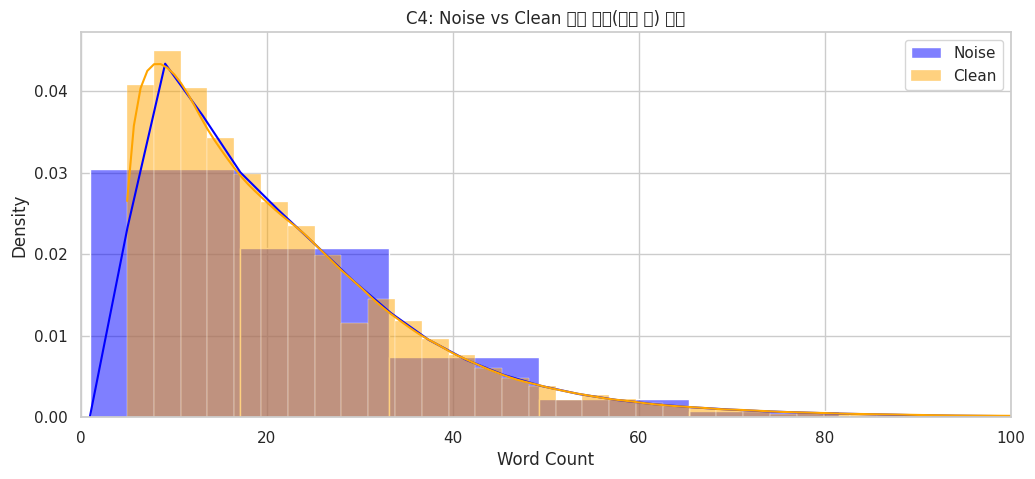

In [21]:
# 단어 수 기준 문장 길이 계산
df["noise_word_len"] = df["noise"].str.split().str.len()
df["clean_word_len"] = df["clean"].str.split().str.len()

plt.figure(figsize=(12, 5))
sns.histplot(df["noise_word_len"], color="blue", label="Noise", kde=True, bins=50, stat="density")
sns.histplot(df["clean_word_len"], color="orange", label="Clean", kde=True, bins=50, stat="density")
plt.title("C4: Noise vs Clean 문장 길이(단어 수) 분포")
plt.xlabel("Word Count")
plt.legend()
plt.xlim(0, 100) # 100개 단어까지만 표시
plt.show()

[해석]

- "noise" 문장의 길이 분포(파란색)와 "clean" 문장의 길이 분포(주황색)이 매우 비슷.
    - "noise"가 문장의 전체 길이에 큰 영향을 주지 않았음
    - 주로 단어를 바꾸거나, 약간의 추가/삭제 방식으로 문장 전체의 길이가 크게 변하지 않음

### `noise` 피처 (편집 거리)

In [ ]:
# Levenshtein (편집 거리) 계산
df["edit_distance"] = df.progress_apply(
    lambda row: Levenshtein.distance(str(row["noise"]), str(row["clean"])),
    axis=1
)

plt.figure(figsize=(12, 5))
sns.histplot(df[df["edit_distance"] > 0]["edit_distance"], binwidth=1, kde=True)
plt.title("C4: Noise-Clean 간 Levenshtein 편집 거리 분포 (No-Op 제외)")
plt.xlabel("Edit Distance")
plt.xlim(0, 20) # 차이가 큰 샘플을 제외하고 집중 분석
plt.show()

print(f"{(df["edit_distance"].between(1, 3)).mean() * 100:.2f}%")

[해석]

- `noise`와 `clean` 문장간 편집 거리가 1~2에서 가장 높은 수를 보이고 점차 감소하는 분포를 보임.
    - 원본 문장에서 한두글자만 수정된 경우가 많다.
    - 단순 오타나 스펠링 오류?
- 편집 거리가 1~3사이 데이터 비율은 약 16.79%
- 문장 구조가 크게 바뀌거나 여러 단어가 수정되는 경우는 상대적으로 적어보임.

### `noise` 피처 (수정 유형)

In [ ]:
def get_word_diff_ops(a, b):
    a_words = str(a).split()
    b_words = str(b).split()
    s = difflib.SequenceMatcher(None, a_words, b_words, autojunk=False)
    op_counts = {"replace": 0, "delete": 0, "insert": 0}

    for tag, i1, i2, j1, j2 in s.get_opcodes():
        if tag != "equal":
            op_counts[tag] += 1 # (i2-i1) 이나 (j2-j1)로 가중치를 줄 수도 있음
    return pd.Series(op_counts)

print("단어 수준 Diff 연산 분석 중...")
diff_df = df[df["edit_distance"] > 0].progress_apply(
    lambda row: get_word_diff_ops(row["noise"], row["clean"]),
    axis=1
)

diff_op_counts = diff_df.sum()

plt.figure(figsize=(8, 5))
diff_op_counts.plot(kind="bar", color=["red", "blue", "green"])
plt.title("C4: 단어 수준 수정 연산(Opcode) 빈도 (No-Op 제외)")
plt.ylabel("Count of Operations")
plt.xticks(rotation=0)
plt.show()

[해석]

- "replace": 스펠링 교정, 단어 교체 위주 예상
- "insert" / "delete": 관사/전치사 삽입/삭제 등 문법적 수정은 "replace"보다 적음
- 스펠링 교정이나 개별 단어 수정은 잘 학습될 것 같지만 문법적 요류는 추가적인 finetuning이 필요함